# TrackNet

The purpose of this net is to estimate probability of a small patch to contain a particle track.
This is done in a pure unsupervised way by comparing different runs under two assumptions:
- one of the runs contains much higher number of particle traces than the other;
- particle traces from one run are indistinguishable against traces from th other and the same for noise.

## Loading data, importing libraries etc.

In [1]:
%env OMP_NUM_THREADS=32
%env THEANO_FLAGS='device=cpu','floatX=float32', 'openmp=True'

DATA_ROOT = '/mnt/crayfis/data/rawcam_masked/'

import numpy as np

import theano
import theano.tensor as T

%matplotlib inline
import matplotlib.pyplot as plt

from crayimage.nn import Expression
from crayimage.utils import NNWatcher
from crayimage.runutils import load_index
from crayimage.imgutils import slice, flatten
from crayimage.runutils import BatchStreams

from lasagne import *

env: OMP_NUM_THREADS=32
env: THEANO_FLAGS='device=cpu','floatX=float32', 'openmp=True'


/opt/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Fancy sampling

The problem with this approach is in training time.
A neural network is conventionally trained by mini-batch gradient descent: network's parameters are updates by gradient from current loss.

Intuitively, large number of noise from both sides
results in zero gradient, and effectively only $\alpha - \beta$ fraction of samples contributes to the gradient, where $\alpha, \beta$ - fraction of samples in the first and the second runs.

With mini-batches the situation is much worse: there is a small probability that a particle trace will be included in a batch, thus most of the batches doesn't contribute to learning at all.

However, we have an idea that the higher the pixel value the higher probability to find a particle trace traveling through this pixel (especially after hot-cell-killing). Using this statistics we can forcibly enrich our batches with traces.
However, if we just increase probability of being selected in a batch for some samples we obtain a biased probability estimation. A better idea is to reweight samples $x_i$ accordingly by weights $w_i$.
In other words, indtead of using convetional loss with uniform sampling over $x_i$:
$$\mathcal{L} = \frac{1}{n} \sum_i l(f(x_i), y_i)$$
use reweighted loss:
$$\mathcal{L}' = \frac{1}{\sum_i w_i} \sum_i w_i l(f(x_i), y_i)$$
with sampling that favours particle traces.

where:
- $f$ - the network estimation;
- $y_i$ - label of dataset;
- $w_i = \frac{p_{\mathrm{batch}}(x_i)}{p(x_i)}$
- $p_{\mathrm{batch}}(x_i)$ - probability of $x_i$ being selected in a batch;
- $p(x_i)$ - prior probability of $x_i$, $p(x_i) = \frac{1}{N}$.

Note that under any adequate $p_{\mathrm{batch}}(x_i)$:
$$\mathbb{E}_{\mathrm{uniform\,by\,} x}\mathcal{L} = \mathbb{E}_\mathrm{x \sim p_{\mathrm{batch}}}\mathcal{L}'$$
and with proper $p_{\mathrm{batch}}(x_i)$:
$$\mathbb{D}_{\mathrm{uniform\,by\,} x}\mathcal{L} \gg \mathbb{D}_\mathrm{x \sim p_{\mathrm{batch}}}\mathcal{L}'$$
thus metric is much stable.

#### Technical details

Quite straight forward approach is to use `np.random.choice(X, size, p=p)` to sample minibatch.
However, it seems like for large `X` the function is extreamely slow (so slow, it is faster not to do reweighting).

A great improvement in speed can be achieved by splitting `X` into baskets, then sample uniformely from baskets.
The method below, just makes a uniform binning by some statistics and samples equal amount of samples from each basket.

#### Example

Image compution some statistic $s(x)$ for $x \sim P$, where $x \in \mathbb{R}^1$ (mini-batch estimation of loss can be considered as a statistic).

Now compare two methods: integration of $p(x)s(x)$ and monte-carlo $\mathrm{mean}(s(x))$.
If distribution of $s(x)$ is a heavy-tailed one, integration would be much accurate/__faster__.

This scheme is a hybrid one. We use integration by a one axis, and Monte-Carlo to compute function value within bins.

In [2]:
def binned_batch_stream(target_statistics, n_epoches, batch_size, n_batches, n_bins=64):
    hist, bins = np.histogram(target_statistics, bins=n_bins)
    indx = np.argsort(target_statistics)
    indicies_categories = np.array_split(indx, np.cumsum(hist)[:-1])
    
    category_ps = hist / np.sum(hist, dtype='float64')
    
    per_category = batch_size / n_bins
    
    weight_correction = (np.float64(hist) / per_category).astype('float32')
    wc = np.repeat(weight_correction, per_category)
    
    def stream():
        for i in xrange(n_batches):
            sample = [
                np.random.choice(ind, size=per_category, replace=True)
                for ind in indicies_categories
            ]

            yield np.hstack(sample), wc
    
    for epoch in xrange(n_epoches):
        yield stream()

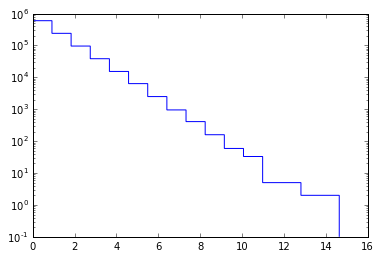

In [3]:
### lets draw some exponentially distributed x
xs = np.random.exponential(scale=1.0, size=10**6)
plt.figure()
_ = plt.hist(xs, histtype='step', bins=16, log=True)

In [4]:
### and estimate mean of x ** 4
true_stat = np.mean(xs ** 4)
print 'Estimated from whole sample:', true_stat

m1 = [
    np.sum(wc * (xs[batch] ** 4)) / np.sum(wc)
    for batch, wc in binned_batch_stream(xs, n_epoches=16, batch_size=128, n_batches=1024, n_bins=8).next()
]

from itertools import islice

m2 = [
    np.mean(xs[batch] ** 4)
    for batch in BatchStreams.random_batch_stream(xs.shape[0], batch_size=128, n_batches=1024)
]

print
### the analytical result is 24
print 'Hybrid sampling: mean s(x) = ', np.mean(m1)
print 'Uniform sampling: mean s(x) = ', np.mean(m2)

print

### the analytical result is 24
print 'Hybrid sampling: std s(x) = ', np.std(m1)
print 'Uniform sampling: std s(x) = ', np.std(m2)

Estimated from whole sample: 24.1222115929

Hybrid sampling: mean s(x) =  24.1628223157
Uniform sampling: mean s(x) =  23.7066624157

Hybrid sampling: std s(x) =  1.73008964017
Uniform sampling: std s(x) =  16.3619255427


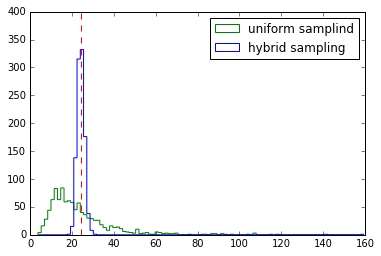

In [5]:
plt.figure()
_ = plt.hist([m1, m2], bins=100, histtype='step', label=['hybrid sampling', 'uniform samplind'])
plt.plot([true_stat, true_stat], [0, 400], '--', label='')
plt.legend()

### Much stable for estimating statistics that heavily depend on tails, isn't it?

Now back to particles.

In [ ]:
### loading info about available runs
runs = load_index('raw_masked.json', DATA_ROOT)

In [ ]:
TARGET = 'Ra226'
AGAINST = 'cal'

In [ ]:
WINDOW=46
STEP=23

In [ ]:
target_run = runs[TARGET]
against_run = runs[AGAINST]

In [ ]:
assert len(set(target_run.meta_info['exposure'])) == 1
target_exposure = list(set(target_run.meta_info['exposure']))[0]

In [ ]:
against_exposure_index = (against_run.meta_info['exposure'] == target_exposure)

In [ ]:
against_run = against_run[against_exposure_index][::5]
target_run = target_run[np.random.choice(len(target_run), size=len(against_run), replace=False)]

In [ ]:
print 'Target run size:', len(target_run)
print 'Target run size:', len(against_run)

In [ ]:
e = flatten(slice(target_run.get_img(0), window=WINDOW, step=STEP))

In [ ]:
e.shape

In [ ]:
X = np.ndarray(shape=(len(target_run) + len(against_run), ) + e.shape, dtype='uint16')
y = np.ndarray(shape=(len(target_run) + len(against_run), e.shape[0]), dtype='uint16')

In [ ]:
print 'Requires memory:', (e.size * 2 / 1024.0 / 1024 / 1024) * (len(target_run) + len(against_run)), 'Gb'

In [ ]:
for i, img in enumerate(target_run):
    X[i] = flatten(slice(img, window=WINDOW, step=STEP))
    y[i] = 1

for i, img in enumerate(against_run, start=len(target_run)):
    X[i] = flatten(slice(img, window=WINDOW, step=STEP))
    y[i] = 0

In [ ]:
img_means = np.mean(X, axis=(1, 2, 3, 4))

In [ ]:
plt.figure()
plt.plot(img_means)

In [ ]:
X = X.reshape(-1, 1, 46, 46)
y = y.reshape(-1)

In [ ]:
m = np.max(X, axis=(1, 2, 3))

In [ ]:
plt.figure()
plt.hist([
    np.mean(X[y == 0], axis=(1, 2, 3)),
    np.mean(X[y == 1], axis=(1, 2, 3)),
], bins=20, log=True, histtype='step', label=['cal', 'Co'])

plt.legend()

In [ ]:
plt.figure()
plt.hist([
    np.std(X[y == 0], axis=(1, 2, 3)),
    np.std(X[y == 1], axis=(1, 2, 3)),
], bins=20, log=True, histtype='step', label=['cal', 'Co'])

plt.legend()

In [ ]:
def elu(x):
    return T.switch(x > 0, x, theano.tensor.exp(x) - 1)

In [ ]:
class TrackNet(Expression):
    def __init__(self, shape = (1, 46, 46), normalization=True):
        self.X_batch = T.tensor4('input patches', dtype='uint16')

        if normalization:
            X_batch_float = self.X_batch.astype('float32')
            X_mean = T.mean(X_batch_float, axis=(1, 2, 3))
            X_std = T.std(X_batch_float, axis=(1, 2, 3))
            X_normed_batch = (X_batch_float - X_mean[:, None, None, None]) / X_std[:, None, None, None]
        else:
            X_batch_float = self.X_batch.astype('float32')
            X_normed_batch = X_batch_float

        self.y_batch = T.fvector('labels')
        self.w_batch = T.fvector('weights')
        
        net = layers.InputLayer(shape=(None, ) + shape, input_var=X_normed_batch)
        
        for i in range(4):
            net = layers.Conv2DLayer(
                net,
                num_filters=2**(3 + i),
                filter_size=(3, 3),
                nonlinearity=elu
            )
            
            net = layers.Pool2DLayer(
                net,
                pool_size=(2, 2),
            )
            
        net = layers.Conv2DLayer(
            net,
            num_filters = 1,
            filter_size=(1, 1),
            nonlinearity = nonlinearities.sigmoid
        )
        
        self.net = net
        
        super(TrackNet, self).__init__(self.X_batch, self.net)

        prediction = layers.get_output(self.net)
        
        self.predict = theano.function([self.X_batch], prediction)
        
        f_prediction = T.flatten(prediction, outdim=1)
        
        log_loss = T.sum(
            self.w_batch * objectives.binary_crossentropy(f_prediction, self.y_batch)
        ) / T.sum(self.w_batch)
        
        self.get_loss = theano.function([self.X_batch, self.w_batch, self.y_batch], log_loss)
        
        reg_coef = T.fscalar('regularization coefficient')
        
        loss = log_loss + reg_coef * regularization.regularize_network_params(self.net, regularization.l2)
        
        learning_rate = T.fscalar('learning rate')
        upd = updates.adadelta(loss, layers.get_all_params(self.net), learning_rate=learning_rate)
        
        self.train = theano.function(
            [self.X_batch, self.w_batch, self.y_batch, reg_coef, learning_rate],
            log_loss,
            updates = upd
        )
    
    def fit(self, X, y,
            sampling_statistics,
            reg_c=1.0e-5, learning_rate = 1.0,
            n_epoches=16, batch_size=128,
            watcher=None):

        size = X.shape[0]
        n_batches = size / batch_size + (1 if size % batch_size != 0 else 0)
        
        pos_class_prior = np.sum(y) / float(y.shape[0])
        neg_class_prior = 1.0 - pos_class_prior

        weights = (np.where(y, 0.5 / pos_class_prior, 0.5 / neg_class_prior) / size).astype('float32')
        
        history = np.zeros(shape=(n_epoches, n_batches), dtype='float32')
        
        batch_stream_factory = binned_batch_stream(
                sampling_statistics,
                n_epoches,
                batch_size, n_batches,
                n_bins=16
            )
        
        for epoch, batch_stream in enumerate(batch_stream_factory):
            for i, (indx, w_correction) in enumerate(batch_stream):
                w_correction = np.ones_like(w_correction)
                history[epoch, i] = self.train(
                    X[indx], y[indx], (weights[indx] * w_correction).astype('float32'),
                    np.float32(reg_c), np.float32(learning_rate)
                )
            
            if watcher is not None:
                watcher.draw(history[:(epoch + 1)])

        return history

In [ ]:
net = TrackNet(normalization=True)

In [ ]:
print net.description()

In [ ]:
watcher = NNWatcher()

In [ ]:
net.fit(
    X, y, m.reshape(-1),
    n_epoches=16, batch_size=256,
    watcher=watcher
)